# Generating Annihilation Rates from Remote Cache of Particle Model
Tim Tyree<br>
11.23.2021

In [1]:
from scipy.optimize import minimize

In [2]:
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [78]:
def comp_rmse_via_interp(x, *args):
    '''find a best r,kappa pair for a given a,D pair for a given full model'''
    a,D,q_values,w_values,interp=args
    r,kappa=x
    #interpolate nu and M using interp
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    # M=yhat[0,2]
    what_values=M*q_values**nu
    rmse_full=np.sqrt(np.mean((what_values-w_values)**2))
    return rmse_full

In [3]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [54]:
# #FK (a_hat short timescale, D_hat long timescale)
a_hat_FK=7.3923;
D_hat_FK=0.365238#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15

a_hat_FK_long = 1.509282#+/-0.178827 cm^2/s, tmax=90
a_hat_FK_vlong = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms


#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'
#msr from the full model
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

#LR (a_hat short timescale, D_hat long timescale)
a_hat_LR=8.595
D_hat_LR=0.586055#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'
a_hat_LR_long = 3.535902#+/-0.312245 cm^2/s, tmax=60

# load the resulting table of powerlaw fits and train interpolation to estimate annihilation rates from the particle model

In [5]:
#neighbor-only forces
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
#vector-summed forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
# df.tail()

In [6]:
testing=False #True yields an extra runtimme of ~2 minutes

#define constant parameters
neighbor=1
# neighbor=0
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#
input_cols=['r','kappa','varkappa','D']#
# output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#2.75 minute runtime paradoxically...
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_cols].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
print(f"training complete!")
if testing:
    yhat = interp(X)
    print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

    rmse=np.sqrt(np.mean((yhat-y)**2))
    print(f"the rmse of simple interpolation is {rmse:.4f}")

number of training examples is 17916.
training complete!
shape of X (17916, 4) --> shape of y=yhat (17916, 2)
the rmse of simple interpolation is 0.0000


# Generate plots of annihilation rates for each apparent parameter setting

## Luo-Rudy

In [71]:
model_name='lr_pbc'
c='C1'
# model_name='fk_pbc'
# c='C0'

#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

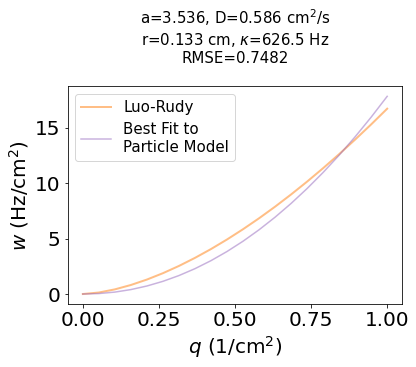

a=3.535902, D=0.586055, r=0.13307032955276987, kappa=626.495291695326, rmse=0.7481539631900532


In [76]:
a=a_hat_LR_long
# a=a_hat_LR
D=D_hat_LR
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
rmse=comp_rmse_via_interp(res.x, *args)
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

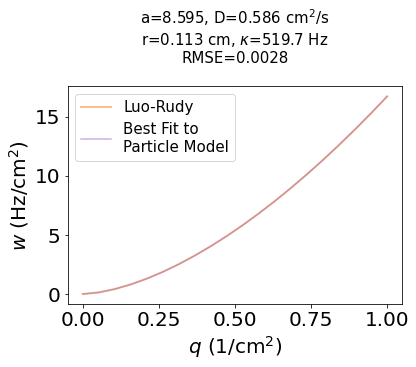

a=8.595, D=0.586055, r=0.11293762983485481, kappa=519.6796928239714, rmse=0.0028255255443067886


In [77]:
# a=a_hat_LR_long
a=a_hat_LR
D=D_hat_LR
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
rmse=comp_rmse_via_interp(res.x, *args)
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

## Fenton-Karma

In [79]:
# model_name='lr_pbc'
# c='C1'
model_name='fk_pbc'
c='C0'

#compute annihilation rates 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

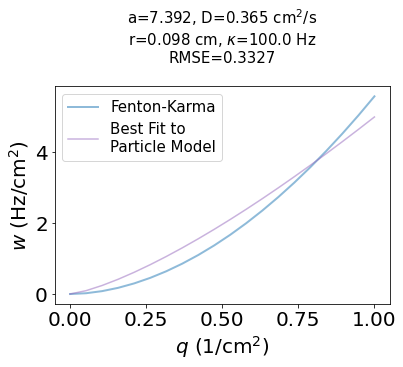

a=7.3923, D=0.365238, r=0.09755432128906222, kappa=100.0, rmse=0.33272882162192


In [80]:
a=a_hat_FK
D=D_hat_FK
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
rmse=comp_rmse_via_interp(res.x, *args)
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

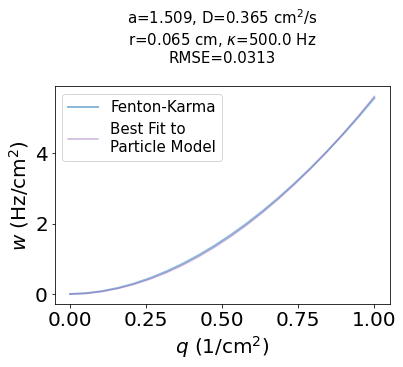

a=1.509282, D=0.365238, r=0.064817053473126, kappa=499.99966444440884, rmse=0.03128880286716598


In [83]:
a=a_hat_FK_long
D=D_hat_FK
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
rmse=comp_rmse_via_interp(res.x, *args)
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

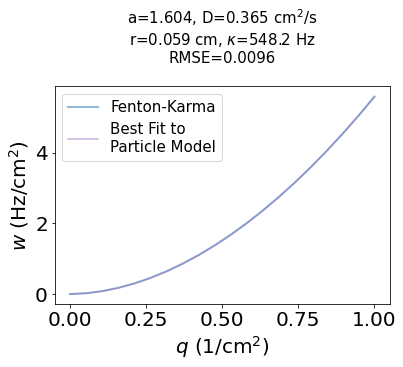

a=1.604153, D=0.365238, r=0.05850407064800177, kappa=548.2299283032432, rmse=0.009568372778984797


In [84]:
a=a_hat_FK_vlong
D=D_hat_FK
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
rmse=comp_rmse_via_interp(res.x, *args)
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

#plot the result over the original annihilation rates
title=f'a={a:.3f}, D={D:.3f}'+r' cm$^2$/s'+f"\nr={r:.3f} cm, "+r'$\kappa$'+f'={kappa:.1f} Hz\nRMSE={rmse:.4f}\n'
plt.plot(q_values,w_values,c=c,label=model_name_string,alpha=0.5,lw=2)
plt.plot(q_values,what_values,c='C4',label='Best Fit to\nParticle Model',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=15)
plt.title(title,fontsize=15)
plt.show()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")